# Business Problem

2K, a gaming company, has recently release it's new annual basketball game, NBA2K21, and they wish to investigate what users think of it. The company plans to use the results of the investigation to inform future game updates and business decisions. We approached the problem by analysing sentiments of posts in the NBA2K subreddit.

# Data Extraction

In [ ]:
from api_funcs import *

In [ ]:
#Import the top 3 posts from the NBA2k subreddit
posts = subreddit_posts('NBA2k', 3)

In [ ]:
posts

In [ ]:
#Get replies from the posts
replies = replies_to_posts(posts)

In [ ]:
replies

In [ ]:
#Turn replies to csv file
replies.to_csv('comments.csv', index=False)

# Preprocessing

In [106]:
#Import libraries
import re
import pandas as pd
import nltk

In [11]:
#Read comments from csv
comments = pd.read_csv('comments.csv')

In [108]:
#Show first 3 rows of comments
comments.head(3)

,Reply,Upvote,Time,Key
0,# Tickets List\n\nI may ask you questions and ...,1,2020-09-09 07:33:42,0
1,Restarted still don’t have my 100k VC. What a...,29,2020-09-07 16:02:21,0
2,100% DID NOT WORK\n\nNo I did not buy the next...,47,2020-09-07 16:26:54,0


In [13]:
#Remove links from comments
comments.Reply = comments.Reply.apply(lambda x: re.sub(r'\(?http\S+', '', x))

In [14]:
#Tokenize words and join to remove new lines
comments.Reply = comments.Reply.apply(lambda x: nltk.word_tokenize(x))
comments.Reply = comments.Reply.apply(lambda x: ' '.join(x))

# Bigrams

In [111]:
comments.head(3)

,Reply,Upvote,Time,Key
0,# Tickets List I may ask you questions and ask...,1,2020-09-09 07:33:42,0
1,Restarted still don ’ t have my 100k VC . What...,29,2020-09-07 16:02:21,0
2,100 % DID NOT WORK No I did not buy the next g...,47,2020-09-07 16:26:54,0


In [112]:
from nltk.collocations import *

#Combine replies into one string separated by a fullstop and space
all_text = comments.Reply.str.cat(sep='. ')

In [113]:
#Tokenize string
all_text = nltk.word_tokenize(all_text)

In [114]:
#Get 10 most common pair of words from string
def common_bigrams(tokenized_text, min_freq, top_n):
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    finder = BigramCollocationFinder.from_words(tokenized_text)
    finder.apply_freq_filter(min_freq)
    finder.nbest(bigram_measures.pmi, top_n)
    return finder.nbest(bigram_measures.pmi, top_n)

print(common_bigrams(all_text, 10, 10))

[('Current', 'Gen'), ('gon', 'na'), ('Series', 'X'), ('patch', 'notes'), ('deleted', ']'), ('[', 'deleted'), ('Good', 'luck'), ('pre', 'order'), ('last', 'night'), ('Locker', 'Codes')]


# Word Cloud

In [115]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

words = comments.Reply.str.cat(sep='. ')

In [116]:
import random

def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(1,20)

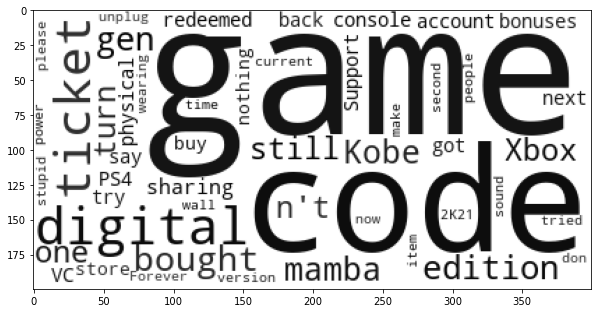

In [117]:
#create word cloud
stp = STOPWORDS.copy() #common words to remove
stp.add('2K')
wc = WordCloud(background_color="white", max_words=50, stopwords=stp, collocations=False)

wc.generate(words)

plt.figure(figsize=(10,20))
plt.imshow(wc.recolor(color_func=grey_color_func, random_state=42))
plt.show()

# Vader

In [16]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer, VaderConstants

#Initialize Vader
sid = SentimentIntensityAnalyzer()

In [17]:
#Copy comments to a new dataframe
df = comments.copy()
df.shape

(1742, 4)

In [22]:
#Group similar words together
lemmatizer = nltk.WordNetLemmatizer()

comments.Reply = comments.Reply.apply(lambda x: ' '.join(
    [lemmatizer.lemmatize(word) for word in nltk.word_tokenize(x)]
))

In [120]:
#Run vader and classify sentiment on each comment of dataframe
df[['neg', 'neu', 'pos', 'compound']] = df.Reply.apply(lambda x: pd.Series(sid.polarity_scores(x)))

In [121]:
df.head()

,Reply,Upvote,Time,Key,neg,neu,pos,compound
0,# Tickets List I may ask you questions and ask...,1,2020-09-09 07:33:42,0,0.008,0.957,0.035,0.6976
1,Restarted still don ’ t have my 100k VC . What...,29,2020-09-07 16:02:21,0,0.178,0.699,0.122,-0.1531
2,100 % DID NOT WORK No I did not buy the next g...,47,2020-09-07 16:26:54,0,0.029,0.721,0.251,0.8682
3,2k gets worse every year Idk why I keep buying...,8,2020-09-09 12:16:04,0,0.333,0.667,0.000,-0.5423
4,"This is a joke , I 'm astounded at the amount ...",8,2020-09-12 10:21:03,0,0.118,0.743,0.140,0.0534


In [145]:
#Count number of positive, neutral, and negative comments

positive = 0
neutral = 0
negative = 0

for index, row in df.iterrows():
    
    #if compound is greater than or equal to 0.05, it's positive
    if row['compound'] >= 0.05:
        positive += 1
        
    #if compound is less than or equal to -0.05, it's negative
    elif row['compound'] <= -0.05:
        negative += 1
        
    #if in between, it's neutral
    else:
        neutral += 1
        
print("Positive comments: " + str(positive))
print("Neutral comments: " + str(neutral))
print("Negative comments: " + str(negative))

Positive comments: 989
Neutral comments: 419
Negative comments: 334


Using vader, we see that there are more positive comments than neutral and negative comments combined, being over twice as large as each of them. This could suggest that more users view NBA2K21 positively, than neutral or negatively.

# Using Kaggle trained Multinomial Naive Bayes Model

In [174]:
#Read train and test data
train = pd.read_csv('train.csv')
test = comments.copy()
test.head()

,Reply,Upvote,Time,Key
0,# Tickets List I may ask you questions and ask...,1,2020-09-09 07:33:42,0
1,Restarted still don ’ t have my 100k VC . What...,29,2020-09-07 16:02:21,0
2,100 % DID NOT WORK No I did not buy the next g...,47,2020-09-07 16:26:54,0
3,2k gets worse every year Idk why I keep buying...,8,2020-09-09 12:16:04,0
4,"This is a joke , I 'm astounded at the amount ...",8,2020-09-12 10:21:03,0


In [175]:
#Remove entries with no text
train.dropna(subset=['text'], inplace=True)
test.dropna(subset=['Reply'], inplace=True)

In [176]:
#Replace characters that aren't space or alphanumeric to empty string
train.text = train.text.apply(lambda x: re.sub(r'[^\w\s]','',x))
test.Reply = test.Reply.apply(lambda x: re.sub(r'[^\w\s]','',x))

In [177]:
#Remove common english words
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
train.text = train.text.apply(lambda x: ' '.join([word for word in nltk.word_tokenize(x) if word.lower() not in stopwords]))
test.Reply = test.Reply.apply(lambda x: ' '.join([word for word in nltk.word_tokenize(x) if word.lower() not in stopwords]))

In [178]:
#Remove links
train.text = train.text.apply(lambda x: re.sub(r'\(?http\S+', '', x))

In [179]:
#Group similar words together
lemmatizer = nltk.WordNetLemmatizer()

train.text = train.text.apply(lambda x: ' '.join(
    [lemmatizer.lemmatize(word) for word in nltk.word_tokenize(x)]
))

test.Reply = test.Reply.apply(lambda x: ' '.join(
    [lemmatizer.lemmatize(word) for word in nltk.word_tokenize(x)]
))

In [180]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

In [181]:
vectorizer = CountVectorizer()

In [183]:
#Vectorize each time a certain word is used in a text
X = vectorizer.fit_transform(train.text)
Y = vectorizer.transform(test.Reply)

In [184]:
#Train using Multinomial Naive Bayes model
nb = MultinomialNB()
nb.fit(X, train.sentiment)

MultinomialNB()

In [185]:
#Predict sentiments of test data
predicted = nb.predict(Y)

In [190]:
test['sentiment'] = predicted
test.head()

,Reply,Upvote,Time,Key,sentiment
0,Tickets List may ask question ask ticket Pleas...,1,2020-09-09 07:33:42,0,neutral
1,Restarted still 100k VC scam hard get bonus it...,29,2020-09-07 16:02:21,0,negative
2,100 WORK buy next gen mamba edition game 8 Kob...,47,2020-09-07 16:26:54,0,negative
3,2k get worse every year Idk keep buying smdh,8,2020-09-09 12:16:04,0,negative
4,joke astounded amount comment 2K essentially s...,8,2020-09-12 10:21:03,0,negative


In [191]:
#Count number of positive, neutral, and negative comments
test['sentiment'].value_counts()

neutral     1373
negative     190
positive     179
Name: sentiment, dtype: int64

# Using Kaggle Trained Recurrent Neural Network

Epoch 1/10
352/352 [==============================] - 13s 38ms/step - loss: 0.8562 - accuracy: 0.5931 - val_loss: 0.5553 - val_accuracy: 0.7948
Epoch 2/10
352/352 [==============================] - 12s 35ms/step - loss: 0.5390 - accuracy: 0.7845 - val_loss: 0.3290 - val_accuracy: 0.8958
Epoch 3/10
352/352 [==============================] - 12s 35ms/step - loss: 0.3331 - accuracy: 0.8772 - val_loss: 0.2280 - val_accuracy: 0.9214
Epoch 4/10
352/352 [==============================] - 13s 36ms/step - loss: 0.2373 - accuracy: 0.9173 - val_loss: 0.1474 - val_accuracy: 0.9563
Epoch 5/10
352/352 [==============================] - 13s 36ms/step - loss: 0.1675 - accuracy: 0.9432 - val_loss: 0.1076 - val_accuracy: 0.9656
Epoch 6/10
352/352 [==============================] - 13s 36ms/step - loss: 0.1270 - accuracy: 0.9583 - val_loss: 0.0987 - val_accuracy: 0.9693
Epoch 7/10
352/352 [==============================] - 13s 36ms/step - loss: 0.1011 - accuracy: 0.9670 - val_loss: 0.0626 - val_accuracy:

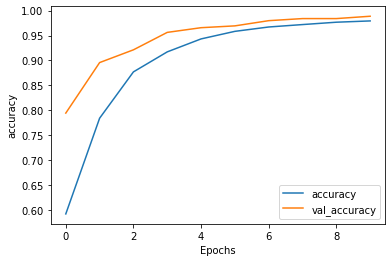

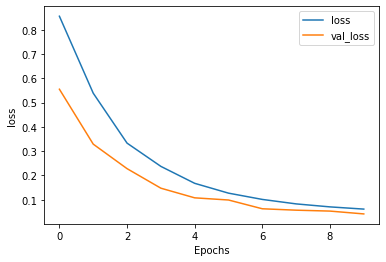

Last session day
Stored 'encoder' (TokenTextEncoder)


TypeError: cannot pickle '_thread.RLock' object

TypeError: cannot pickle '_thread.RLock' object

In [8]:
import import_ipynb

%run Kaggle_Sentiment_Analysis.ipynb

In [23]:
comments.head()

,Reply,Upvote,Time,Key
0,Tickets List may ask question ask ticket Pleas...,1,2020-09-09 07:33:42,0
1,Restarted still 100k VC scam hard get bonus it...,29,2020-09-07 16:02:21,0
2,100 WORK buy next gen mamba edition game 8 Kob...,47,2020-09-07 16:26:54,0
3,2k get worse every year Idk keep buying smdh,8,2020-09-09 12:16:04,0
4,joke astounded amount comment 2K essentially s...,8,2020-09-12 10:21:03,0


In [24]:
comments.size

6968

In [30]:
#Count number of positive, neutral, and negative comments

positive = 0
neutral = 0
negative = 0

for text in comments.Reply:
    predictions = sample_predict(text, pad=True)
    
    #Assume negative has highest value
    highest = 0
    
    if predictions[0][1] > predictions[0][highest]:
        highest = 1
    
    if predictions[0][2] > predictions[0][highest]:
        highest = 2
    
    if highest == 0:
        negative += 1
    elif highest == 1:
        neutral += 1
    else:
        positive += 1
    
print("Positive comments: " + str(positive))
print("Neutral comments: " + str(neutral))
print("Negative comments: " + str(negative))

Positive comments: 238
Neutral comments: 1238
Negative comments: 266


Using the Kaggle trained models, we see that there's a lot more neutral sentiments than either positive or negative. This could be because the dictionary is a lot smaller compared to pretrained models like Vader. This means a lot more sentences will be viewed as neutral as the model doesn't have know enough of the words contained in the sentences to be able to decide whether they are positive or negative.